# Princess Sakura Main #

## Imports ##

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim

In [6]:
# Read the CSV file
first_blooms = pd.read_csv("data/kaggle-cherry-blossom/sakura_first_bloom_dates.csv")

In [7]:
first_blooms

,Site Name,Currently Being Observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
0,Wakkanai,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,1959-05-03,1960-05-19,...,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,2021-05-08,2022-05-06,2023-05-03,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,1959-05-08,1960-05-13,...,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,2021-04-29,2022-04-26,2023-04-25,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaN,NaN,1959-05-03,NaN,...,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,2021-05-06,2022-04-27,2023-04-28,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaN,1959-05-05,1960-05-05,...,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,2021-04-22,2022-04-23,2023-04-15,5 1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Kumejima,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Taiwan cherry (Prunus campanulata)
98,Naha,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-01-21,2017-01-14,2018-01-10,2019-01-10,2020-01-06,2021-01-04,2022-01-11,2023-01-07,1 16,Taiwan cherry (Prunus campanulata)
99,Nago,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Taiwan cherry (Prunus campanulata)
100,Iriomote Island,False,NaN,NaN,1955-01-07,NaN,1957-01-16,NaN,1959-01-12,1960-02-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Taiwan cherry (Prunus campanulata)


In [43]:
def get_lat_long(city):
    geolocator = Nominatim(user_agent="my-app")
    location = geolocator.geocode(city)
    if location is None:
        return None, None
    return location.latitude, location.longitude

In [39]:
def find_weather_data(site_name, start, end, replace_snow_prcp_nans=True):
    '''Get the daily weather data for the site nearest to the given site name.

    Parameters
    ----------
    site_name : str
        The name of the site.
    start : datetime
        The start date of the weather data.
    end : datetime
        The end date of the weather data.
    replace_snow_prcp_nans : bool
        If True, replace the NaNs in snow and prcp the weather data with 0.

    Returns
    -------
    data : pandas.DataFrame
        The daily weather data for the site nearest to the given site name.
    '''
    latitude, longitude = get_lat_long(site_name + ", Japan")

    # Fetch the nearest station
    stations = Stations()
    nearest_station = stations.nearby(latitude, longitude).fetch(1)

    # Fetch the daily weather data
    data = Daily(nearest_station.index[0], start, end)
    data = data.fetch()
    data.reset_index(inplace=True)
    data["Site Name"] = site_name

    if replace_snow_prcp_nans:
        # Replace the NaNs in snow and prcp with 0
        data["snow"] = data["snow"].fillna(0)
        data["prcp"] = data["prcp"].fillna(0)

    return data


In [48]:
first_blooms['Latitude'], first_blooms['Longitude'] = zip(*first_blooms['Site Name'].apply(lambda site: get_lat_long(site + ", Japan")))

In [49]:
first_blooms['Latitude'].isna().sum()

3

In [37]:
tokyo_daily = find_weather_data("Tokyo", datetime(1952, 1, 1), datetime(2023, 12, 9))

In [36]:
tokyo_daily

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Site Name
0,1953-01-01,6.1,-0.9,14.4,0.0,0.0,339.0,27.8,NaN,1017.3,NaN,Tokyo
1,1953-01-02,0.9,1.6,4.7,0.0,0.0,342.0,10.2,NaN,1026.4,NaN,Tokyo
2,1953-01-03,1.8,-3.8,7.3,0.0,0.0,355.0,16.1,NaN,1026.4,NaN,Tokyo
3,1953-01-04,1.4,-2.9,6.7,0.0,0.0,5.0,11.0,NaN,1029.9,NaN,Tokyo
4,1953-01-05,2.4,-1.6,5.3,17.2,0.0,331.0,13.8,NaN,1013.6,NaN,Tokyo
...,...,...,...,...,...,...,...,...,...,...,...,...
25538,2023-12-05,8.1,5.8,10.5,1.1,0.0,325.0,6.8,NaN,1019.8,NaN,Tokyo
25539,2023-12-06,10.9,7.4,15.3,3.1,0.0,4.0,6.7,NaN,1012.1,NaN,Tokyo
25540,2023-12-07,12.8,8.8,18.0,0.0,0.0,252.0,10.0,NaN,1006.7,NaN,Tokyo
25541,2023-12-08,11.9,7.5,16.7,0.0,0.0,243.0,8.0,NaN,1018.9,NaN,Tokyo


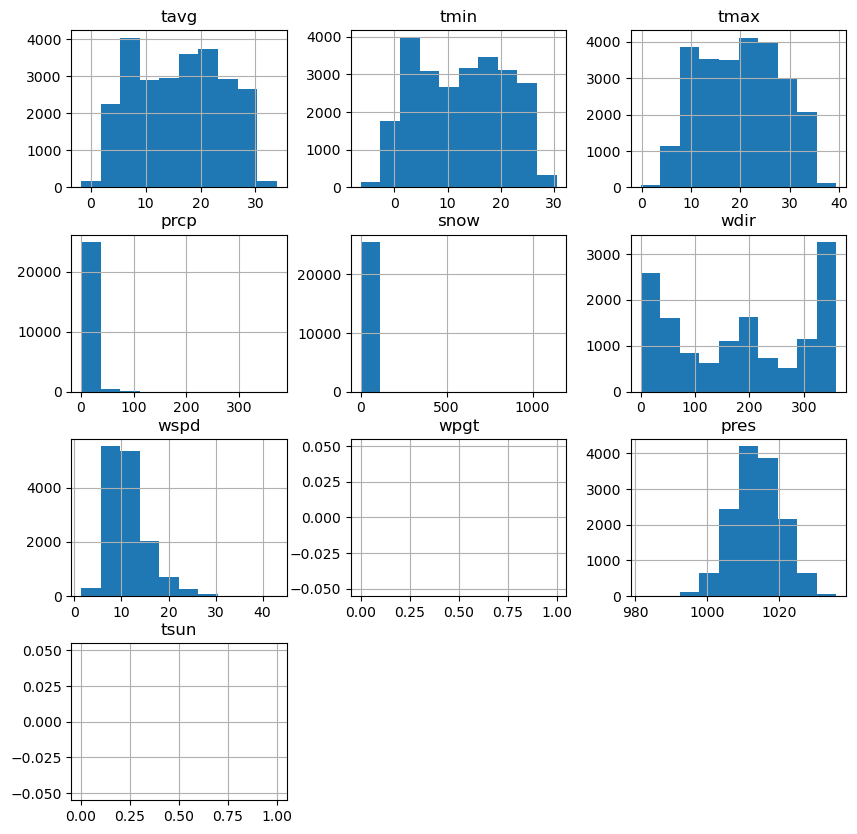

In [28]:
tokyo_daily.hist(figsize=(10, 10))
plt.title("Tokyo Daily Weather Data from 1952 to 2023")
plt.show()

In [9]:
for site in first_blooms["Site Name"]:
    data = find_weather_data(site, datetime(1953, 1, 1), datetime(2023, 12, 9))
    print(site)
    print(data.head())

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2010-01-01,5.3,0.2,9.5,0.0,NaN,292.0,7.3,NaN,1003.5,NaN
2010-01-02,6.4,0.9,11.4,0.0,NaN,288.0,6.2,NaN,1007.9,NaN
2010-01-03,6.0,1.4,9.2,0.0,NaN,340.0,8.4,NaN,1007.7,NaN
2010-01-04,6.6,4.0,9.3,0.0,NaN,326.0,7.8,NaN,1013.1,NaN
2010-01-05,7.4,3.0,13.2,2.5,NaN,314.0,12.6,NaN,1003.2,NaN
...,...,...,...,...,...,...,...,...,...,...
2010-12-27,6.9,2.7,11.3,0.0,NaN,242.0,7.9,NaN,1005.0,NaN
2010-12-28,8.2,2.1,11.5,0.0,NaN,270.0,8.3,NaN,1007.1,NaN
2010-12-29,7.6,5.2,12.6,0.0,NaN,319.0,10.7,NaN,1004.6,NaN


In [2]:
# Create a geocoder object
geolocator = Nominatim(user_agent="my_app")

# Get the location of Tokyo
location = geolocator.geocode("Tokyo, Japan")

# Extract the latitude and longitude
latitude = location.latitude
longitude = location.longitude

print("Latitude:", latitude)
print("Longitude:", longitude)

Latitude: 35.6821936
Longitude: 139.762221


In [ ]:
# Create a Stations object
stations = Stations()

# Search for stations near Tokyo, Japan
stations = stations.nearby(35.6895, 139.6917)

# Get the nearest station
nearest_station = stations.fetch(1)

# Print the nearest station information
print(nearest_station)


# Fetch Historical Weather Data with Meteostat #

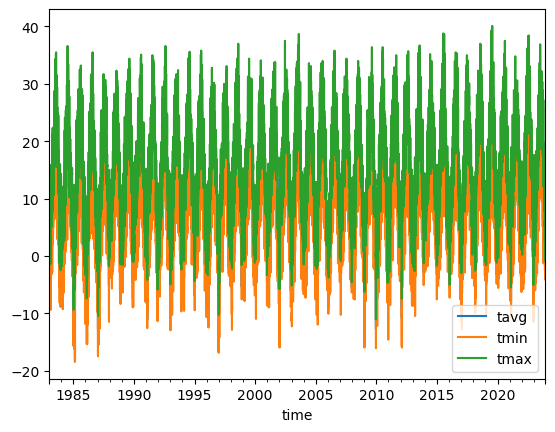

In [16]:
# Set time period
start = datetime(1983, 1, 1)
end = datetime(2023, 12, 4)

# Get daily data
data = Daily("10637", start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()